# RPS Detector

Notebook ini menjelaskan implementasi detektor Rock, Paper, Scissors menggunakan tensorflow.

## Biodata

Notebook ini dibuat oleh
* Nama: Bayu Samudra
* Github: https://github.com/bayusamudra014

## Requirements

Untuk menjalankan notebook ini, diperlukan dependensi berikut:
1. Python 3.11.9
2. Tensorflow 2.16.1
3. Numpy 1.26.4
4. Matplotlib 3.9.0
5. Sckit-Learn 1.5.0

In [1]:
import os

import tensorflow as tf
import numpy as np
import sklearn
import matplotlib as mt
import matplotlib.pyplot as plt

from keras import losses, models, layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix

2024-07-10 15:02:12.117986: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 15:02:12.156314: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 15:02:12.844465: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.__version__)
print(np.version.full_version)
print(mt.__version__)
print(sklearn.__version__)

2.16.1
1.26.4
3.9.0
1.5.0


## Dataset

Dataset yang digunakan adalah [Dataset Rock Paper Scissor](https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip) dari Dicoding.

In [3]:
# !wget --no-check-certificate \
#   https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
#   -O /tmp/rps.zip

## Data Preparation

Bagian ini menjelaskan terkait dengan persiapan data. Pada bagian ini, dataset akan dilakukan pelabelan dan augmentasi gambar.

In [4]:
BASE_FOLDER = "."

In [5]:
TRAINING_DIR = f"{BASE_FOLDER}/data"
os.listdir(TRAINING_DIR)

['paper', 'rock', 'scissors']

In [6]:
TARGET_SIZE = (150,150)

Berikut ini merupakan proses import gambar dan pemrosesan gambar. Dalam prosesing, ditambahkan juga hasil color map menjadi menggunakan grayscale. Tujuan dari penambahan ini adalah untuk menghindari model terbiaskan oleh warna latar.

In [7]:
train_datagen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=20,
  horizontal_flip=True,
  shear_range = 0.2,
  fill_mode = 'nearest',
  validation_split=0.4,
)

train_generator = train_datagen.flow_from_directory(
  TRAINING_DIR,
  target_size=TARGET_SIZE,
  class_mode='categorical',
  batch_size=126,
  subset='training',
  color_mode='grayscale',
)

validation_generator = train_datagen.flow_from_directory(
  TRAINING_DIR,
  target_size=TARGET_SIZE,
  class_mode='categorical',
  batch_size=126,
  subset='validation',
  color_mode='grayscale'
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


## Model

Bagian ini menjelaskan terkait dengan model yang akan digunakan untuk memprediksi kelas `paper`, `scissor`, dan `rock`.

In [8]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*TARGET_SIZE, 1)),
    layers.MaxPooling2D(3, 3),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(3,3),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(3,3),
    layers.Flatten(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax'),
])

/home/miawheker/.pyenv/versions/tensorflow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-10 15:02:14.227594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 15:02:14.264924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Doc

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,193,923 (8.37 MB)

 Trainable params: 2,193,923 (8.37 MB)

 Non-trainable params: 0 (0.00 B)

Berikut merupakan proses _learning_ yang dilakukan.

In [10]:
model.compile(loss=losses.CategoricalCrossentropy(),
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [11]:
model.fit(
      train_generator,
      epochs=25,
      validation_data=validation_generator
)

Epoch 1/25


/home/miawheker/.pyenv/versions/tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1720598538.347750  175129 service.cc:145] XLA service 0x7f8568003db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720598538.347777  175129 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-07-10 15:02:18.391905: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-10 15:02:18.559610: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cu

 2/11 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2619 - loss: 1.1333 

I0000 00:00:1720598549.777312  175129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.3091 - loss: 1.1242

I0000 00:00:1720598558.686842  175465 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_95', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1720598559.192220  175470 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_95', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1720598559.260295  175475 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_95', 460 bytes spill stores, 348 bytes spill loads

I0000 00:00:1720598559.302982  175467 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_95', 944 bytes spill stores, 616 bytes spill loads

I0000 00:00:1720598561.291826  175521 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_95', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1720598561.833703  175516 

11/11 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3134 - loss: 1.1219 - val_accuracy: 0.3432 - val_loss: 1.0968
Epoch 2/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.3379 - loss: 1.0957 - val_accuracy: 0.3432 - val_loss: 1.0810
Epoch 3/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - accuracy: 0.4116 - loss: 1.0649 - val_accuracy: 0.5435 - val_loss: 1.0163
Epoch 4/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.5398 - loss: 0.9775 - val_accuracy: 0.7620 - val_loss: 0.8077
Epoch 5/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - accuracy: 0.6442 - loss: 0.7767 - val_accuracy: 0.7952 - val_loss: 0.5936
Epoch 6/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.8092 - loss: 0.5370 - val_accuracy: 0.8581 - val_loss: 0.4740
Epoch 7/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - accuracy: 0.8317 - loss: 0.4430 - val_accuracy: 0.9005 - val_loss: 0.3467
Epoch 8/25
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 302ms/step - accuracy: 0.8989 - loss: 0.3151 - val_accuracy: 0.9211 - val_lo

## Evaluation

Pada bagian ini, akan dicoba untuk melakukan evaluasi model. Dataset yang digunakan untuk pengujian ini adalah dataset yang dibuat sendiri.

In [12]:
y_pred = []
y_true = []

for i in os.listdir(f"{BASE_FOLDER}/additional_test/paper"):
  img = image.load_img(f"{BASE_FOLDER}/additional_test/paper/{i}", target_size=TARGET_SIZE, color_mode='grayscale')
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  result = model.predict(img)
  y_pred.append(np.argmax(result))
  y_true.append(0)

for i in os.listdir(f"{BASE_FOLDER}/additional_test/rock"):
  img = image.load_img(f"{BASE_FOLDER}/additional_test/rock/{i}", target_size=TARGET_SIZE, color_mode='grayscale')
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  result = model.predict(img)
  y_pred.append(np.argmax(result))
  y_true.append(1)

for i in os.listdir(f"{BASE_FOLDER}/additional_test/scissors"):
  img = image.load_img(f"{BASE_FOLDER}/additional_test/scissors/{i}", target_size=TARGET_SIZE, color_mode='grayscale')
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)
  result = model.predict(img)
  y_pred.append(np.argmax(result))
  y_true.append(2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [13]:
accuracy_score(y_true, y_pred)

1.0

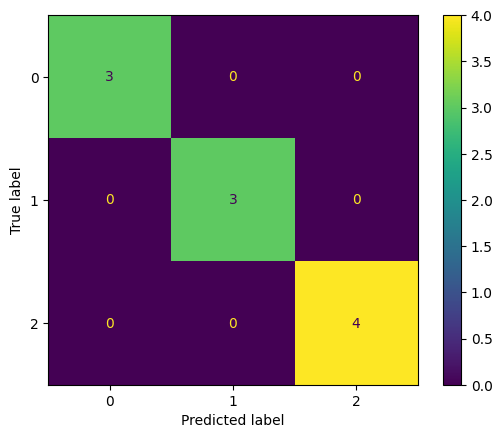

In [14]:
res = confusion_matrix(y_true, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=res)

display.plot()

## Demo

Berikut ini merupakan bagian untuk demostrasi program

In [15]:
# from google.colab import files
# %matplotlib inline

# uploaded = files.upload()
uploaded = ["data/paper/0Uomd0HvOB33m47I.png"]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction class: paper


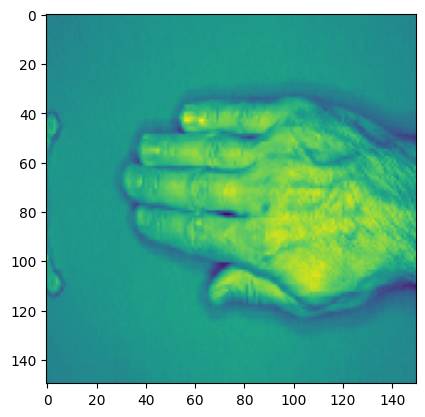

In [16]:
for path in uploaded:
  img = image.load_img(path, 
            target_size=TARGET_SIZE, 
            color_mode='grayscale'
        )
    
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)

  print("Prediction class: ", end="")
  
  if np.argmax(classes[0]) == 0:
    print('paper')
  elif np.argmax(classes[0]) == 1:
    print('rock')
  else:
    print('scissors')
  plt.show()